In [1]:
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd

In [2]:
files = glob.glob('.\\data\\ha_temp_*.png')

In [3]:
# reference tick labels to determine y axis scale

tick_label_20 = np.array([
    [1, 0, 0, 0, 0, 0, 1],
    [0, 0, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 0, 1],
    [1, 1, 1, 0, 0, 1, 1],
    [1, 1, 0, 0, 1, 1, 1],
    [1, 0, 0, 1, 1, 1, 1],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0] ])

tick_label_40 = np.array([
    [1, 1, 1, 1, 0, 0, 1],
    [1, 1, 1, 0, 0, 0, 1],
    [1, 1, 0, 0, 0, 0, 1],
    [1, 0, 0, 1, 0, 0, 1],
    [0, 0, 1, 1, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 1],
    [1, 1, 1, 1, 0, 0, 1],
    [1, 1, 1, 0, 0, 0, 0] ])

In [4]:
temperatures = []
names = []

for file in files:

    # extract date from filename
    name = file.split('_')[-3]
    name = name[-2:] + '.' + name[4:6] + '.' + name[:4]
    names.append(name)

    # read image
    img = mpimg.imread(file)

    # grayscale image
    gray = img[..., :3].mean(axis=2)

    # Threshold: find dark pixels (line)
    line_mask = (gray > 0.6) * 1

    # determine y-axis scale by checking the tick labels (max either 20°C or 40°C)
    tick_label = line_mask[56:65, 30:37]
    y_max = (
          (np.max(tick_label - tick_label_20) == 0) * 20 
        + (np.max(tick_label - tick_label_40) == 0) * 40 )

    # Extract the y-pixel number of the line
    line_y = np.nan * np.ones(line_mask.shape[1])
    for x in range(line_mask.shape[1]):
        y_indices = np.where(line_mask[:, x] == 0)[0]
        if len(y_indices) > 0:
            line_y[x] = y_indices[0]  # take the first (topmost) pixel

    # convert pixels to values
    # y-pixel 267 corresponds to temperature 0
    # y-pixel  66 corresponds to temperature y_max
    temperatures.append(y_max * (line_y[49:-26] - 267) / (66 - 267))

# x-pixel  48 corresponds to hour 0
# x-pixel -16 corresponds to hour 24
min_max_hour = 24 * (np.array([49, 960-26]) - 48) / (960-16 - 48)
hour = np.linspace(min_max_hour[0], min_max_hour[1], len(temperatures[-1]))

# Create a DataFrame
temperatures = pd.DataFrame(np.array(temperatures).T, index=hour, columns=names)

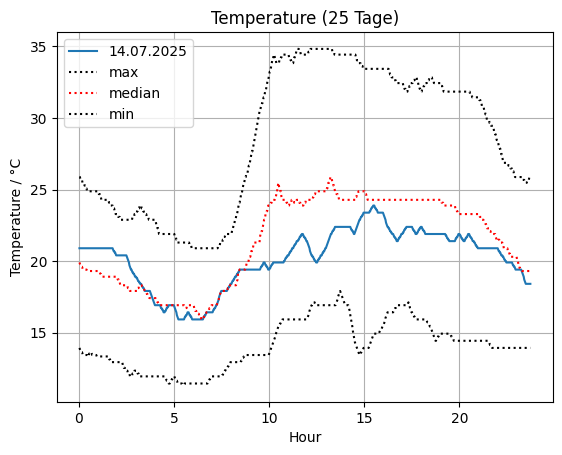

In [5]:
temperatures['median'] = temperatures.median(axis=1)
temperatures['min']    = temperatures.min(axis=1)
temperatures['max']    = temperatures.max(axis=1)

temperatures.plot(y=[name,'max','median','min'], style=['-','k:','r:','k:'], 
           title=f'Temperature ({temperatures.shape[1]-3} Tage)', 
           ylabel='Temperature / °C', xlabel='Hour', grid=True)
plt.show()